In [2]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

/Users/darkgengar/Documents/python_projects/Python-AI-Agent/myagent/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [3]:
class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int
    

In [4]:
    def greeting_node(state: AgentState) -> AgentState:
        """"greeting node to person"""
        state["name"] = f"Hi there, {state["name"]}"
        state["counter"] = 0

        return state

    def random_node(state: AgentState) -> AgentState:
        """generate a number"""
        state["number"].append(random.randint(0,10))
        state["counter"] +=1
    
        return state

    def should_continue(state: AgentState) -> AgentState:
        """func to decide what to do nxt"""
        if state["counter"] < 5:
            print("Entering loop", state["counter"])
            return "loop" # continue loop
        else:
            return "exit"
            

In [5]:
    graph = StateGraph(AgentState)

    graph.add_node("greeting", greeting_node)
    graph.add_node("random", random_node)
    graph.add_edge("greeting", "random")

    graph.add_conditional_edges(
        "random", # src code
        should_continue, # route func
        {
            "loop": "random", #self loop back to same code
            "exit": END
        }
    )

    graph.set_entry_point("greeting")

    app = graph.compile()

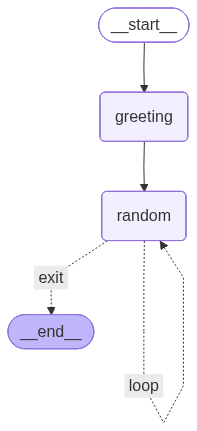

In [8]:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
app.invoke({"name": "Farhan", "number":[], "counter":-1})

Entering loop 1
Entering loop 2
Entering loop 3
Entering loop 4


{'name': 'Hi there, Farhan', 'number': [5, 5, 2, 1, 1], 'counter': 5}

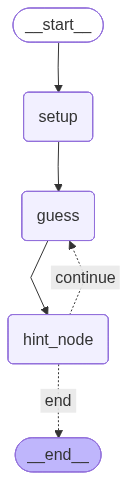

In [11]:
#excercise 5

from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int 
    upper_bound: int 

def setup_node(state: AgentState) -> AgentState:
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1 
    state["upper_bound"] = 20 
    print(f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20.")
    return state

def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        
        guess = random.randint(state["lower_bound"], state["upper_bound"])
    
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")
    return state

def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]
    
    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"
        
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")
    
    return state

def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)  


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")  


graph.add_conditional_edges(
    "hint_node", 
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))
            
    
